**Gestione Energetica ed Automazione negli Edifici (GEAE) A.A. 2024/2025**

*Tutto il materiale didattico messo a disposizione degli studenti (compresi script, markdown, presentazioni, video e Virtual Classroom) è da utilizzarsi esclusivamente per scopi didattici e nell’ambito del corso di “gestione energetica e automazione negli edifici”. È vietata ogni forma di utilizzo diverso, redistribuzione e pubblicazione on line. Per ogni eventuale dubbio o richiesta contattare il titolare del corso prof. Alfonso Capozzoli a alfonso.capozzoli@polito.it*

# Pattern recognition through SAX

## Introduction

### Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from datetime import datetime
from scipy.stats import zscore

import matplotlib.dates as mdates

### Importing data

In [2]:
df = pd.read_csv('../data/pydata.csv', parse_dates=['date_time'])
df_info = pd.read_csv('../data/df_info.csv')

### Adding 'date' and 'time' columns

In [3]:
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.time

1. **`pydata['date'] = pydata['date_time'].dt.date`**
   - This line creates a new column called `'date'` in the `pydata` DataFrame.
   - **`pydata['date_time']`** refers to an existing column that contains datetime values.
   - **`.dt.date`** extracts the date part from each datetime entry (i.e., year, month, and day) and stores it in the `'date'` column.

2. **`pydata['time'] = pydata['date_time'].dt.time`**
   - This line creates another new column called `'time'` in the `pydata` DataFrame.
   - **`.dt.time`** extracts the time part from each datetime entry (i.e., hours, minutes, and seconds) and stores it in the `'time'` column.

## SAX Transformation

### Identification of time windows for time series reduction

In [4]:
spl = ["00:00", "04:00", "08:00", "12:00", "16:00", "20:00", "23:59"]
spl_times = [datetime.strptime(t, "%H:%M").time() for t in spl]

`spl_times = [datetime.strptime(t, "%H:%M").time() for t in spl]`
 - `datetime.strptime(t, "%H:%M")`: This part of the code parses each string `t` in the `spl` list as a `datetime` object, interpreting the format `"%H:%M"` (hours and minutes).
  - `.time()`: After parsing, the `time()` method extracts the time portion (hours and minutes) from the `datetime` object, ignoring any date information.
  - The list comprehension `[ ... for t in spl]` iterates over each time string `t` in the `spl` list and applies the conversion, resulting in a list of `time` objects.

### Defining the function to assign periods

In [5]:
def assign_period(row):
    time = row['time']
    if time < spl_times[1]:
        return "Period_1"
    elif time < spl_times[2]:
        return "Period_2"
    elif time < spl_times[3]:
        return "Period_3"
    elif time < spl_times[4]:
        return "Period_4"
    elif time < spl_times[5]:
        return "Period_5"
    else:
        return "Period_6"



# Apply the function to assign periods
df['period'] = df.apply(assign_period, axis=1)

1. `def assign_period(row):` This function is designed to determine a period based on the `time` value in each row of a DataFrame. It uses predefined time intervals (`spl_times`) to assign a specific period label.
2. `df['period'] = df.apply(assign_period, axis=1)`: This line applies the `assign_period` function to each row of the DataFrame `df`, adding a new column (`period`) that stores the result of the function for each row. The `axis=1` argument ensures the function is applied to rows (rather than columns).

### Z-normalization of the energy consumption

In [6]:
df['znorm'] = zscore(df['energy_h'])

- This line creates a new column called `znorm` in the DataFrame `df`, which contains the z-scores of the `energy_h` column.
- **`zscore(df['energy_h'])`**: The `zscore` function calculates the **z-score** for each value in the `energy_h` column.
  - The **z-score** is a statistical measurement that describes a value's relationship to the mean of the dataset. It is calculated as the number of standard deviations a value is from the mean.
  - The z-score for a value `x` is calculated using the formula:
    z = (x - `μ`)/(`σ`)
    where:
    - `x` is the data point.
    - `μ` is the mean of the column.
    - `σ` is the standard deviation of the column.
  - The result is a standardized value (or z-score), making it easier to compare data points from different scales or distributions.
  - After applying `zscore`, each value in `df['znorm']` will indicate how many standard deviations the corresponding value in `df['energy_h']` is from the mean of that column.


### Aggregating the time series using Piecewise Aggregate Approximation (PAA)

In [7]:
df_PAA = df.groupby(['date', 'period']).agg({'znorm': 'mean'}).reset_index()
df_PAA.rename(columns={'znorm': 'znorm_mean'}, inplace=True)

- This code creates a new DataFrame called `df_PAA` by aggregating the `znorm` values in the original `df` based on the combination of `date` and `period` columns.
  
- **`df.groupby(['date', 'period'])`**: The `groupby` function groups the data by unique combinations of the `date` and `period` columns.
  - Each unique combination of `date` and `period` forms a group.

- **`.agg({'znorm': 'mean'})`**: The `.agg()` method applies an aggregation function to the grouped data.
  - In this case, it calculates the **mean** of the `znorm` values within each group (i.e., for each unique `date` and `period` combination).
  - This results in the average z-score (`znorm`) for each combination of `date` and `period`.

- **`.reset_index()`**: This method resets the index of the resulting DataFrame.
  - After grouping and aggregating, `date` and `period` become part of the index. The `reset_index()` method turns them back into regular columns, making the DataFrame easier to work with.

- **`df_PAA.rename(columns={'znorm': 'znorm_mean'}, inplace=True)`**: This line renames the `znorm` column in the new DataFrame to `znorm_mean`.
  - **`columns={'znorm': 'znorm_mean'}`**: Specifies that the `znorm` column should be renamed to `znorm_mean`.
  - **`inplace=True`**: The renaming is done directly on the `df_PAA` DataFrame, modifying it in place.
  
- The final result is a DataFrame `df_PAA` where each row contains the mean `znorm` value for a specific `date` and `period` combination, with the mean z-scores stored in the `znorm_mean` column.


### Encoding of the aggregated time series in 5 symbols using the lookup table

In [8]:
breakpoints = [-0.84, -0.25, 0.25, 0.84]

def assign_symbol(value):
    if value <= breakpoints[0]:
        return 'A'
    elif value <= breakpoints[1]:
        return 'B'
    elif value <= breakpoints[2]:
        return 'C'
    elif value <= breakpoints[3]:
        return 'D'
    else:
        return 'E'

df_PAA['symbol'] = df_PAA['znorm_mean'].apply(assign_symbol)

- This block of code assigns categorical symbols (`'A'`, `'B'`, `'C'`, `'D'`, `'E'`) to the `znorm_mean` values in the `df_PAA` DataFrame based on predefined breakpoints.

- **`breakpoints = [-0.84, -0.25, 0.25, 0.84]`**: Defines a list of **breakpoints** that segment the z-scores (`znorm_mean`) into different ranges.
  - The list contains four numeric values: `-0.84`, `-0.25`, `0.25`, and `0.84`. These values represent the thresholds for assigning each symbol category.

- **`def assign_symbol(value):`**: Defines a function `assign_symbol` that takes a numerical value as input (in this case, the `znorm_mean` value) and returns a corresponding symbol based on the breakpoints.


- **`df_PAA['symbol'] = df_PAA['znorm_mean'].apply(assign_symbol)`**: This line applies the `assign_symbol` function to each value in the `znorm_mean` column of `df_PAA`.
  - **`.apply(assign_symbol)`**: The `.apply()` method applies the `assign_symbol` function to each row in the `znorm_mean` column.
  - The result is a new column called `symbol` in the `df_PAA` DataFrame, containing the symbols `'A'`, `'B'`, `'C'`, `'D'`, or `'E'` based on the z-score ranges defined by the breakpoints.


In [9]:
pydata = pd.merge(df, df_PAA[['date', 'period', 'symbol']], on=['date', 'period'], how='left')

- This line merges the original DataFrame `df` with a subset of columns from the DataFrame `df_PAA`, creating a new DataFrame called `pydata`.

- **`pd.merge(df, df_PAA[['date', 'period', 'symbol']], on=['date', 'period'], how='left')`**: This is a Pandas **merge** operation that combines two DataFrames (`df` and a subset of `df_PAA`) based on matching values in the `date` and `period` columns.
  
  - **`df`**: The original DataFrame containing the main data.
  
  - **`df_PAA[['date', 'period', 'symbol']]`**: A subset of the `df_PAA` DataFrame that only includes the `date`, `period`, and `symbol` columns. 
    - **`[['date', 'period', 'symbol']]`**: This selects only these specific columns from `df_PAA`, allowing the merge to combine these columns with `df`.

  - **`on=['date', 'period']`**: Specifies that the merge should be performed by matching rows where the values in the `date` and `period` columns are the same in both DataFrames.
    - Rows where both the `date` and `period` columns match between `df` and `df_PAA` will be merged together.

  - **`how='left'`**: Specifies a **left join**, meaning all rows from the `df` DataFrame will be retained, even if there is no corresponding row in `df_PAA`.
    - If no match is found in `df_PAA` for a given `date` and `period`, the `symbol` column in the resulting DataFrame `pydata` will be filled with `NaN`.

### Visualization of the SAX transformation

In [10]:
pivot_df = pydata.pivot_table(index='date', columns='time', values='symbol', aggfunc='first')

# Define custom color mapping
symbol_colors = {
    'A': '#5591ff',
    'B': '#40c8ff',
    'C': '#ffd954',
    'D': '#7fdd56',
    'E': '#ed6f6f'
}

In [11]:
cmap = ListedColormap([symbol_colors[key] for key in sorted(symbol_colors.keys())])

symbol_to_num = {symbol: idx for idx, symbol in enumerate(sorted(symbol_colors.keys()))}
numeric_data = pivot_df.replace(symbol_to_num)

C:\Users\silvio.brandi\AppData\Local\Temp\ipykernel_13332\2388236346.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_data = pivot_df.replace(symbol_to_num)


1. `cmap = ListedColormap([symbol_colors[key] for key in sorted(symbol_colors.keys())])`: This line creates a **custom colormap** using the color mapping defined in `symbol_colors`, which will be used for plotting or visualizing the symbols.

- **Explanation**:
  - **`ListedColormap([...])`**: `ListedColormap` is a function from Matplotlib that creates a colormap from a list of colors. 
  - **`[symbol_colors[key] for key in sorted(symbol_colors.keys())]`**: This list comprehension extracts the colors from `symbol_colors`, sorting the dictionary keys (symbols 'A' to 'E') to ensure a consistent color order. 
    - **`sorted(symbol_colors.keys())`**: Sorts the keys (symbols) in ascending order, resulting in the sequence `['A', 'B', 'C', 'D', 'E']`.
    - **`symbol_colors[key]`**: For each symbol key, the corresponding color from `symbol_colors` is retrieved.
  - The final result is a **colormap** (`cmap`) with the colors assigned to symbols 'A', 'B', 'C', 'D', and 'E' in that order.

2. `symbol_to_num = {symbol: idx for idx, symbol in enumerate(sorted(symbol_colors.keys()))}`: This line creates a **mapping** from each symbol ('A', 'B', 'C', 'D', 'E') to a corresponding numeric value (0, 1, 2, 3, 4). This is needed for plotting since symbols cannot be directly visualized, but numeric values can.

- **Explanation**:
  - **`enumerate(sorted(symbol_colors.keys()))`**: The `sorted(symbol_colors.keys())` part sorts the symbols alphabetically ('A' to 'E'), and `enumerate` assigns an index (starting from 0) to each symbol.
  - **`symbol: idx`**: For each symbol in the sorted list, the symbol becomes the dictionary key, and its corresponding numeric index (from `enumerate`) becomes the value.
  - **Result**: A dictionary where symbols are mapped to numeric values:
    - `'A': 0`, `'B': 1`, `'C': 2`, `'D': 3`, `'E': 4`.

3. `numeric_data = pivot_df.replace(symbol_to_num)`: This line replaces the symbols in the `pivot_df` DataFrame with their corresponding numeric values using the `symbol_to_num` mapping.

- **Explanation**:
  - **`pivot_df.replace(symbol_to_num)`**: The `replace` method looks for each symbol in the `pivot_df` and replaces it with the corresponding numeric value from the `symbol_to_num` dictionary.
  - **Result**: `numeric_data` is a new DataFrame where each symbol ('A', 'B', 'C', 'D', 'E') in the original `pivot_df` has been replaced by its corresponding numeric value (0, 1, 2, 3, 4). This transformed data can now be easily used for visualization, such as plotting with the previously defined colormap (`cmap`).


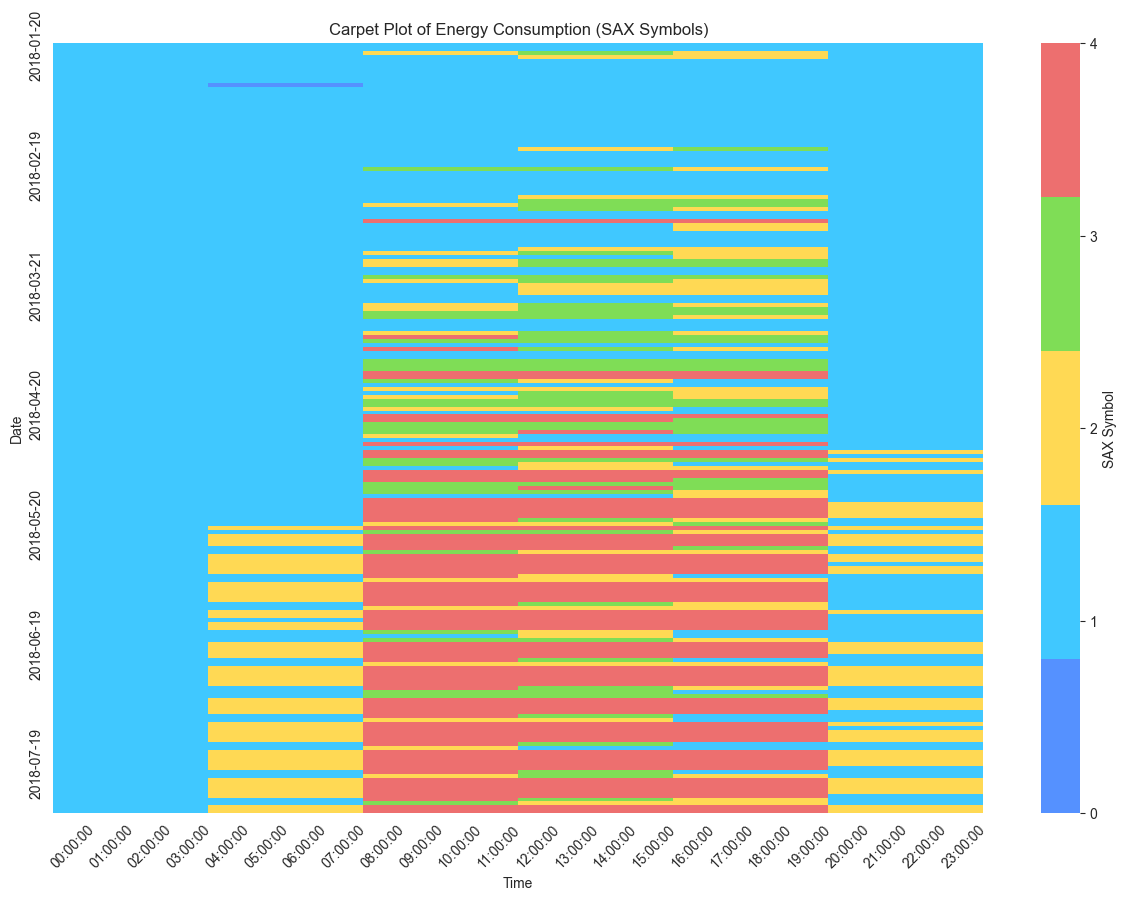

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_data, cmap=cmap, cbar_kws={'ticks': list(symbol_to_num.values()), 
                                               'label': 'SAX Symbol'}, yticklabels=30)
plt.title('Carpet Plot of Energy Consumption (SAX Symbols)')
plt.xlabel('Time')
plt.ylabel('Date')

plt.xticks(rotation=45)
plt.show()

## Construction of the daily words as a combination of subsequent symbols 

### Pivot the PAA DataFrame to have the symbols of each period in columns

In [13]:
df_PAA_pivot = df_PAA.pivot(index='date', columns='period', values='symbol').reset_index()

### Ensuring the order of the periods

In [14]:
periods = ['Period_1', 'Period_2', 'Period_3', 'Period_4', 'Period_5', 'Period_6']
df_PAA_pivot = df_PAA_pivot[['date'] + periods]

1. `periods = ['Period_1', 'Period_2', 'Period_3', 'Period_4', 'Period_5', 'Period_6']`: This line defines a list called `periods`, containing the names of different periods (`Period_1` to `Period_6`).

2. `df_PAA_pivot = df_PAA_pivot[['date'] + periods]`: This line reorders the columns of the `df_PAA_pivot` DataFrame, ensuring that the first column is `date`, followed by the columns corresponding to the periods (`Period_1` to `Period_6`).

### Concatenating the symbols of the periods to form the daily words

In [15]:
df_PAA_pivot['word'] = df_PAA_pivot[periods].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

`df_PAA_pivot['word'] = df_PAA_pivot[periods].apply(lambda row: ''.join(row.values.astype(str)), axis=1)`: This line creates a new column called `word` in the `df_PAA_pivot` DataFrame. The column is populated with concatenated string representations of the symbols found in the columns corresponding to each period (`Period_1` to `Period_6`) for each row.

- **Explanation**:
  - **`df_PAA_pivot[periods]`**: This selects the columns `Period_1`, `Period_2`, ..., `Period_6` from the DataFrame, as defined by the `periods` list.
  
  - **`.apply(lambda row: ''.join(row.values.astype(str)), axis=1)`**: The `apply()` function applies a function to each row in the selected columns.
    - **`lambda row: ''.join(row.values.astype(str))`**: This anonymous function (lambda function) is applied to each row:
      - **`row.values.astype(str)`**: Converts the values in the row to string format. This is necessary because the values in the period columns might not all be strings by default (they could be numeric or categorical).
      - **`''.join(...)`**: Concatenates the string representations of the values in the row into a single string, without any spaces or delimiters.
  
  - **`axis=1`**: Ensures that the function is applied across each row, rather than across columns. This means the concatenation happens row-wise for all periods (`Period_1` to `Period_6`).

- **Result**: The new column `word` contains a string of concatenated period symbols for each row. For example, if a row has symbols `'A'`, `'B'`, `'C'`, `'D'`, `'E'`, and `'A'` in the period columns, the corresponding `word` will be `'ABCDEA'`.

### Counting the frequency of daily words

In [16]:
word_counts = df_PAA_pivot['word'].value_counts().reset_index()
word_counts.columns = ['word', 'count']

df_PAA_pivot = pd.merge(df_PAA_pivot, word_counts, on='word')

1. `word_counts = df_PAA_pivot['word'].value_counts().reset_index()`: This line calculates the frequency (count) of each unique word (the concatenated symbol strings) in the `word` column of the `df_PAA_pivot` DataFrame. The result is stored in a new DataFrame `word_counts`.

- **Explanation**:
  - **`df_PAA_pivot['word'].value_counts()`**: This counts the occurrences of each unique string in the `word` column, returning a Series where the index is the unique words and the values are the counts (i.e., how many times each word appears).
  - **`.reset_index()`**: Converts the Series generated by `value_counts()` into a DataFrame, with the index (the unique words) becoming a column. This is necessary for merging the result back into `df_PAA_pivot` later.

- **Result**: The resulting `word_counts` DataFrame has two columns:
  - The first column (`index`, which will be renamed later) contains the unique `word` values.
  - The second column contains the count of how many times each word appears in the original `df_PAA_pivot` DataFrame.

2. `word_counts.columns = ['word', 'count']`: This line renames the columns of the `word_counts` DataFrame for better readability.


3. `df_PAA_pivot = pd.merge(df_PAA_pivot, word_counts, on='word')`: This line merges the original `df_PAA_pivot` DataFrame with the `word_counts` DataFrame, adding the `count` of each word (the frequency) as a new column to `df_PAA_pivot`.

### Sorting the words based on their frequency

In [17]:
df_PAA_pivot['word'] = pd.Categorical(df_PAA_pivot['word'], categories=word_counts['word'], ordered=True)

`df_PAA_pivot['word'] = pd.Categorical(df_PAA_pivot['word'], categories=word_counts['word'], ordered=True)`: This line converts the `word` column in the `df_PAA_pivot` DataFrame into a **categorical type** with a specific order based on the frequency of the words, as defined by the `word_counts['word']`.

- **Explanation**:
  - **`pd.Categorical(df_PAA_pivot['word'])`**: Converts the `word` column into a **Categorical** data type. A categorical variable takes on a limited, fixed number of possible values (categories), which can be ordered or unordered.
  
  - **`categories=word_counts['word']`**: Specifies the ordering of the categories for the `word` column. The `word_counts['word']` provides a list of words sorted by frequency (since `word_counts` was created using `value_counts()`, which by default orders words by their frequency, from most to least frequent).
    - This ensures that the categories in the `word` column are sorted in the same order as they appear in `word_counts`, meaning the most frequent words come first.

  - **`ordered=True`**: Specifies that the categories should be treated as **ordered**. This means that comparisons between categories are now meaningful (e.g., one word can be considered "greater" or "lesser" than another based on their order).

- **Result**: The `word` column in `df_PAA_pivot` is now a **categorical** column with an imposed order based on the frequency of the words. This allows for more efficient storage and enables ordered comparisons or sorted operations on the `word` column based on the specified category order.


### Plot the frequency of words

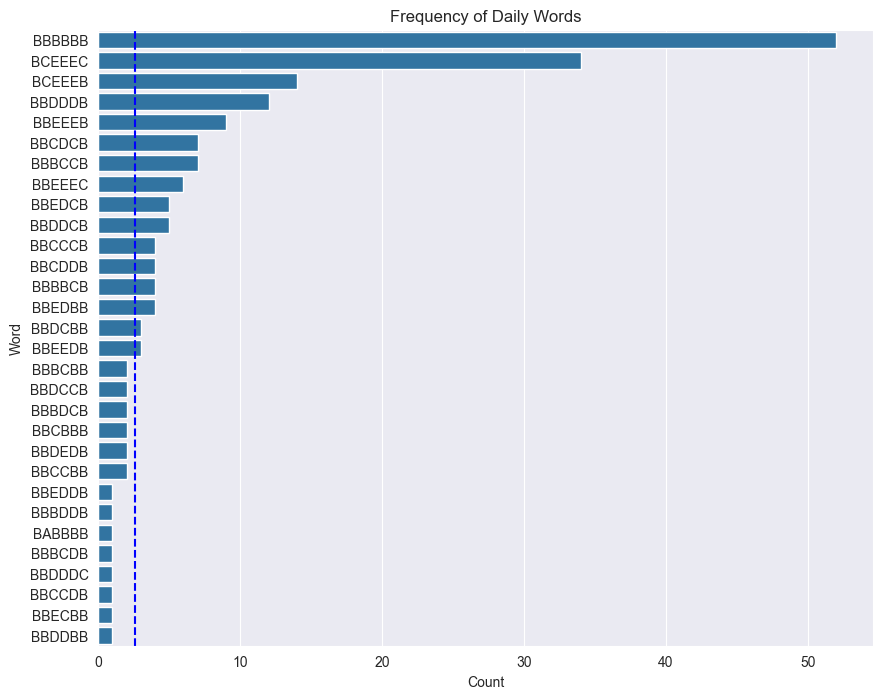

In [21]:
# Plot frequency of words
plt.figure(figsize=(10, 8))
sns.countplot(y='word', data=df_PAA_pivot, order=word_counts['word'])
plt.axvline(0.05 * df_PAA_pivot['word'].value_counts().max(), color='blue', linestyle='--')
plt.title('Frequency of Daily Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

## Determining motifs and discords

### Setting a threshold for motifs and discords

In [19]:
threshold = 0.1 * df_PAA_pivot['count'].max()

df_PAA_pivot['pattern'] = df_PAA_pivot['count'].apply(lambda x: 'discord' if x < threshold else 'motif')

pydata = pd.merge(pydata, df_PAA_pivot[['date', 'word', 'pattern']], on='date', how='left')

pydata['time_dt'] = pd.to_datetime(pydata['time'].astype(str), format='%H:%M:%S')

### Plot the motifs and discords

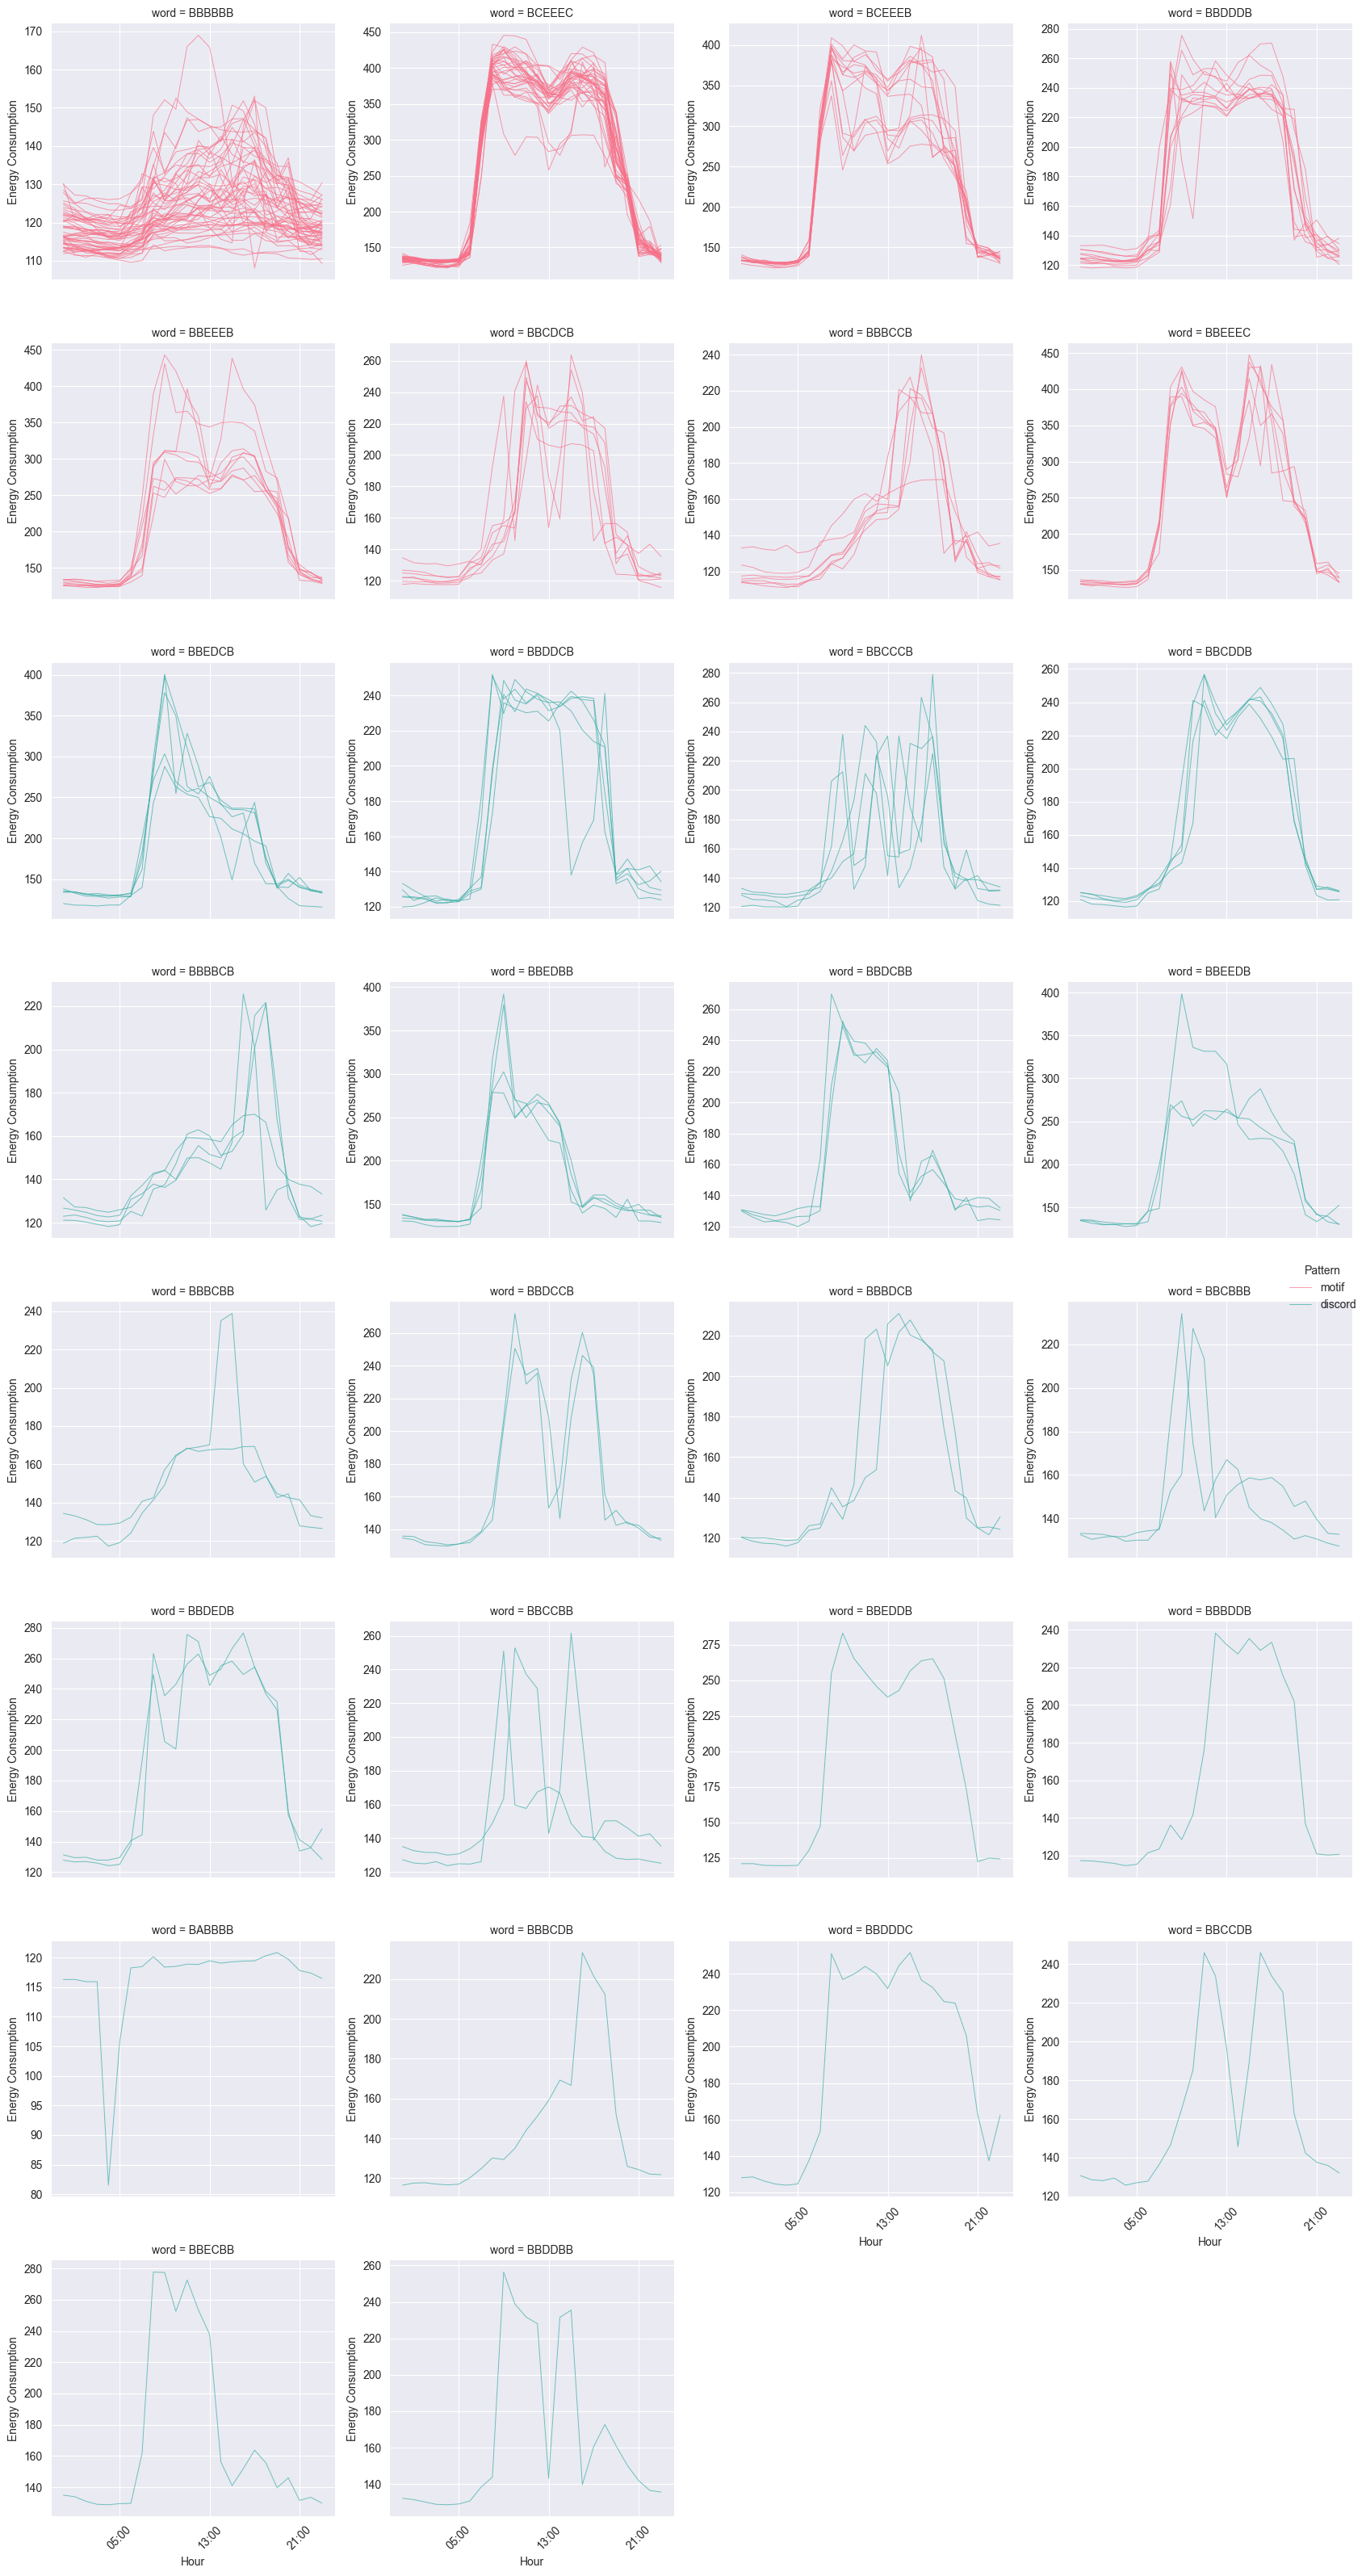

In [20]:
palette = sns.color_palette("husl", len(pydata['pattern'].unique()))


g = sns.FacetGrid(pydata, col='word', col_wrap=4, height=4, sharey=False, hue='pattern', palette=palette)
g.map_dataframe(sns.lineplot, x='time_dt', y='energy_h', estimator=None, units='date', lw=0.7, alpha=0.7)

# Adjust plot aesthetics
for ax in g.axes.flatten():
    ax.set_xlabel('Hour')
    ax.set_ylabel('Energy Consumption')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=8))
    plt.setp(ax.get_xticklabels(), rotation=45)

# Add a legend for 'pattern'
g.add_legend(title="Pattern")

plt.tight_layout()
plt.show()

1. `g = sns.FacetGrid(pydata, col='word', col_wrap=4, height=4, sharey=False)`: This line creates a **FacetGrid** using Seaborn, which allows for the creation of multiple subplots (facets), where each subplot corresponds to a unique value of the `word` column in the `pydata` DataFrame.

- **Explanation**:
  - **`sns.FacetGrid(pydata)`**: Initializes a `FacetGrid` object with the `pydata` DataFrame as the source of data.
  - **`col='word'`**: Specifies that a separate subplot (facet) should be created for each unique value in the `word` column. Each facet will display data for a different concatenated symbol sequence.
  - **`col_wrap=4`**: Arranges the subplots in a grid with at most 4 columns per row. After reaching 4 columns, a new row starts.
  - **`height=4`**: Sets the height of each facet (subplot) to 4 inches.
  - **`sharey=False`**: Ensures that the y-axes are **not** shared between subplots, allowing each subplot to have its own independent y-axis scale. This is useful when the ranges of the `energy_h` values vary across different `word` categories.

2. `g.map_dataframe(sns.lineplot, x='time_dt', y='energy_h', hue='pattern', estimator=None, units='date', lw=0.7, alpha=0.7)`: This line maps a **lineplot** onto each subplot (facet) in the grid, using the data from the `pydata` DataFrame. It plots the `energy_h` values over time (`time_dt`), differentiating the lines by the `pattern` column.

- **Explanation**:
  - **`g.map_dataframe(sns.lineplot, ...)`**: The `map_dataframe()` method applies a Seaborn plotting function (`sns.lineplot` in this case) to the data in each facet (subplot).
    - **`sns.lineplot`**: Creates a line plot for each subset of data corresponding to a unique `word` value (each facet). 
    - **`x='time_dt'`**: Plots the time dimension (`time_dt`) on the x-axis.
    - **`y='energy_h'`**: Plots the `energy_h` (energy consumption) values on the y-axis.
    - **`hue='pattern'`**: Differentiates the lines in each facet based on the `pattern` column, assigning different colors to different patterns.
    - **`estimator=None`**: Prevents any aggregation or smoothing of the data, so all the raw data points are plotted as-is.
    - **`units='date'`**: Ensures that the data is grouped by the `date` column. This means each line corresponds to a specific date in the dataset.
    - **`lw=0.7`**: Sets the line width to 0.7, making the lines thin and less visually dominant.
    - **`alpha=0.7`**: Sets the transparency level of the lines to 0.7, making them slightly transparent to better visualize overlapping data.

- **Result**: The resulting plot shows multiple subplots (facets), with each subplot corresponding to a unique value of the `word` column. Each subplot contains a series of lines representing the energy consumption (`energy_h`) over time (`time_dt`), differentiated by the `pattern` column. The transparency and thin lines help to visualize overlapping data more clearly.

3. Formatting Axes and Layout

- **`for ax in g.axes.flatten():`**
  - Iterates over each axis (subplot) in the `FacetGrid`. The `g.axes.flatten()` method converts the grid of axes into a 1D array for easy iteration over each subplot.

- **`ax.set_xlabel('Hour')` and `ax.set_ylabel('Energy Consumption')`**
  - These lines set the x-axis label to "Hour" and the y-axis label to "Energy Consumption" for each subplot. This adds clear labels to the axes, making the plot more understandable.

- **`ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))`**
  - Formats the x-axis to display the time in `Hour:Minute` format. This ensures that the x-axis shows times in a readable format, especially since `time_dt` is being used for the x-axis.

- **`ax.xaxis.set_major_locator(mdates.HourLocator(interval=8))`**
  - Sets major tick marks on the x-axis at 8-hour intervals, making the time labels more spaced out and less cluttered.

- **`plt.setp(ax.get_xticklabels(), rotation=45)`**
  - Rotates the x-axis tick labels by 45 degrees, ensuring that the labels do not overlap and are easier to read.

- **`plt.tight_layout()`**
  - Optimizes the layout of the subplots so that there is no overlap between elements (e.g., axis labels, titles). This ensures that all subplots and labels fit nicely within the figure.

- **`plt.show()`**
  - Displays the final plot with the customized formatting applied. This renders the entire grid of subplots with the adjusted axes, labels, and layout.
